In [2]:
# Prueba 9-7-2024 00:05

In [2]:
#importacion  de librerias
import numpy as np
import pandas as pd
import uuid
import random 
from datetime import datetime, timedelta 

In [3]:
#funcion para generar IDs Unicos
def generate_unique_id():
    return str(uuid.uuid4()) 
    

In [4]:
#  creacion de la funcion para crear dataframes  
def create_dataframe(config, existing_dataframes):
    columns = config['columns']  
    data = {}
    max_length = 0  

    # Primero, determinamos max_length
    for col in columns:
        if col['type'] == 'category':
            values = col['values']
            if len(values) > max_length:
                max_length = len(values)
        elif col['type'] == 'date':
            min_date = datetime.strptime(col['values']['min'], "%Y-%m-%d")
            max_date = datetime.strptime(col['values']['max'], "%Y-%m-%d")
            date_range = (max_date - min_date).days + 1
            if date_range > max_length:
                max_length = date_range
        elif col['type'] == 'foreign':
            dataset_name, column_name = col['values'].split('.')
            if dataset_name not in existing_dataframes:
                raise ValueError(f"Dataset {dataset_name} not found.")
            if column_name not in existing_dataframes[dataset_name].columns:
                valid_columns = ", ".join(existing_dataframes[dataset_name].columns)
                raise ValueError(f"Column {column_name} not found in dataset {dataset_name}. Valid columns are: {valid_columns}.")
            foreign_values = existing_dataframes[dataset_name][column_name].unique()
            if len(foreign_values) > max_length:
                max_length = len(foreign_values)

    # Luego, generamos los datos con max_length conocido
    for col in columns:
        if col['type'] == 'category':
            values = col['values']
            data[col['name']] = (values * (max_length // len(values)) + values[:max_length % len(values)])[:max_length]
        elif col['type'] == 'unique':
            data[col['name']] = [generate_unique_id() for _ in range(max_length)]
        elif col['type'] == 'date':
            min_date = datetime.strptime(col['values']['min'], "%Y-%m-%d")
            max_date = datetime.strptime(col['values']['max'], "%Y-%m-%d")
            date_range = (max_date - min_date).days + 1
            data[col['name']] = [min_date + timedelta(days=i) for i in range(date_range)][:max_length]
        elif col['type'] == 'foreign':
            dataset_name, column_name = col['values'].split('.')
            foreign_values = existing_dataframes[dataset_name][column_name].unique()
            data[col['name']] = random.choices(foreign_values, k=max_length)

    dataframe = pd.DataFrame(data)  # Creamos un dataframe con los datos generados.
    return dataframe
def build_dataframes(config_list):
    dataframes = {}
    
    for config in config_list:
        df_name = config['ds']
        df = create_dataframe(config, dataframes)  
        dataframes[df_name] = df
    
    return dataframes


In [8]:
# creacion de las configuraciones de los parametros de cada dataframe

# Definimos la configuración para el primer dataframe, 'empleados'.
dicc_emp = {
    "ds": "Empleados",  
    "columns": [  
        {
            "name": "departamento",  
            "type": "category",  
            "values": ["RRHH", "Finanzas", "IT", "Marketing"]  
        },
        {
            "name": "Empleado_id",  
            "type": "unique"  
        }
    ],
    "random": False  
}

# Definimos la configuración para el segundo dataframe, 'Empleado_det'.
dicc_emp_det = {
    "ds": "Empleado_det",  
    "columns": [  
        {
            "name": "det_id", 
            "type": "unique" 
        },
        {
            "name": "departamento", 
            "type": "foreign", 
            "values": "Empleados.departamento"  
        },
        {
            "name": "role",  
            "type": "category", 
            "values": ["Gerente", "Analista", "Developer", "Desarrollador"]  
        }
    ],
    "random": False  
}

# Definimos la configuración para el tercer dataframe, 'salarios'.
dicc_sal = {
    "ds": "salarios",  
    "columns": [ 
        {
            "name": "salary_id",  
            "type": "unique"  
        },
        {
            "name": "role",  
            "type": "foreign",  
            "values": "Empleado_det.role"  
        },
        {
            "name": "salario",  
            "type": "numeric",  
            "values": {"min": 30000, "max": 120000}  
        },
        {
            "name": "bonificaciones",  
            "type": "numeric", 
            "values": {"min": 5000, "max": 20000, "std": 3000, "mean": 10000}  
        }
    ],
    "random": True,  
    "random_rows": 1000  
}

# Creamos una lista con las configuraciones de los dataframes.
conf_list = [dicc_emp, dicc_emp_det, dicc_sal]


In [10]:

# Generación de los dataframes basados en la lista creada anteriormente
dataframe_list = build_dataframes(conf_list)


In [12]:
# Simulacion y analisis de los datos 

def generate_numeric_values(config): 
    if "std" in config and "mean" in config:
        
        mean = config["mean"] 
        std = config["std"]    
        min_val = config["min"]  
        max_val = config["max"]   
        values = np.random.normal(loc=mean, scale=std, size=1000)
        values = [max(min_val, min(max_val, x)) for x in values]
    else:
        min_val = config["min"] 
        max_val = config["max"]  

        values = np.random.uniform(min_val, max_val, 1000)
    
    return values  

def get_categorical_dataset_simulated(df, category_cols, num_records):
    probabilities = df[category_cols].value_counts(normalize=True)
    sampled_df = probabilities.sample(n=num_records, replace=True, weights=probabilities.values).reset_index()
    return sampled_df  # Devuelve el DataFrame muestreado.

def get_numeric_column_simulated(df, config, category_cols, numeric_col):
   
    if 'columns' in config:
        numeric_config_list = [col for col in config['columns'] if col['name'] == numeric_col]
       
        if numeric_config_list:
            numeric_config = numeric_config_list[0]
            numeric_values = generate_numeric_values(numeric_config['values'])
            extended_df = df.copy()  
            extended_df[numeric_col] = np.random.choice(numeric_values, size=len(df), replace=True)
        else:
            raise ValueError(f"No configuration found for numeric column '{numeric_col}'.")
    else:
        raise ValueError("Configuration does not contain 'columns' information.")

    return extended_df  

simulation_extended = dataframe_list["salarios"]
category_cols = ["role"]
numeric_cols = ["salario", "bonificaciones"]

final_simulation = get_categorical_dataset_simulated(simulation_extended, category_cols, 100000)


for nc in numeric_cols:
   
    dfn = get_numeric_column_simulated(simulation_extended, conf_list[2], category_cols, nc)
    final_simulation = pd.merge(final_simulation, dfn[[nc]], left_index=True, right_index=True)

print(final_simulation.head())



       role  proportion        salario  bonificaciones
0   Gerente        0.50   35032.906428    12887.107090
1   Gerente        0.50   88143.344027     5000.000000
2  Analista        0.25  113773.964807    10315.797673
3   Gerente        0.50   76580.524042     7832.916302


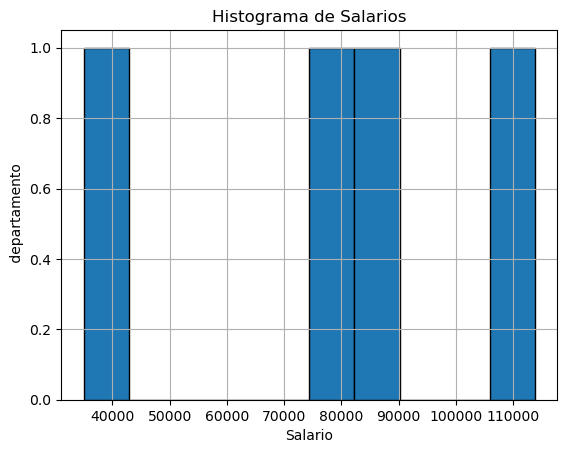

In [14]:
import matplotlib.pyplot as plt


# Crear el histograma
plt.hist(final_simulation['salario'], bins=10, edgecolor='black')  
plt.xlabel('Salario')
plt.ylabel(' departamento')
plt.title('Histograma de Salarios')
plt.grid(True)
plt.show()